In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from preprocess import *
from train import *
from nn import *
from metric import *

/home/jennifer/miniconda3/envs/MathAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data=process(train_data)
test_data =process2(test_data)

X_train = get_X(train_data , ["Pclass", "Sex", "family", "is_baby", "name_title"])
y_train = get_y(train_data )
X_test = get_X(test_data, ["Pclass", "Sex", "family", "is_baby", "name_title"])



In [3]:
import torch
from nn import *
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from train import train_one_epoch, evaluate
from torchmetrics.classification import BinaryConfusionMatrix, BinaryAccuracy
import time
import os

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset


n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2023)

nets = [ANN(input_dim=14).to(device) for i in range(n_splits)]
history = []

best_avg_val_loss = float('inf')  # Track the best average validation loss
best_model_filename = None

for i, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
  X, y = torch.tensor(X_train[trn_idx]), torch.tensor(y_train[trn_idx]).unsqueeze(-1)
  X_val, y_val = torch.tensor(X_train[val_idx]), torch.tensor(y_train[val_idx]).unsqueeze(-1)

  # ds = TensorDataset(X, y)
  # ds_val = TensorDataset(X_val, y_val)
  ds = TensorDataset(X, y)
  ds_val = TensorDataset(X_val, y_val)
  dl = DataLoader(ds, batch_size=32, shuffle=True)
  dl_val = DataLoader(ds_val, batch_size=len(ds_val), shuffle=False)

  net = nets[i]
  optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

  best_val_loss = float('inf')
  patience = 5  # You can adjust this based on your preference
  early_stop_counter = 0
  history_val_loss = []

  pbar = tqdm(range(300))
  for j in pbar:
    accuracy = BinaryAccuracy().to(device)
    loss = train_one_epoch(net, nn.functional.binary_cross_entropy, optimizer, dl, device)
    loss_val = evaluate(net, nn.functional.binary_cross_entropy, dl_val, device, accuracy)
    acc_val = accuracy.compute().item()
    pbar.set_postfix(trn_loss=loss, val_loss=loss_val, val_acc=acc_val)

    history_val_loss.append(loss_val)  # Store validation loss for each epoch

    # Save the best model based on validation loss
    if loss_val < best_val_loss:
      best_val_loss = loss_val
      
       # Save the model with filename
      model_filename =  f'fold_{i}_best_model'
      model_path = os.path.join("./model", model_filename)
      torch.save(net.state_dict(), model_path)  # Save the model
      
      # Reset early stopping counter
      early_stop_counter = 0
    else:
      # Increment early stopping counter
      early_stop_counter += 1

    # Check for early stopping
    if early_stop_counter >= patience:
      print(f'Early stopping at epoch {j} for fold {i}.')
      break

  # Update the best average validation loss and filename
  avg_val_loss = sum(history_val_loss) / len(history_val_loss)
  if avg_val_loss < best_avg_val_loss:
    best_avg_val_loss = avg_val_loss
    best_model_filename = model_filename  

  bcm = BinaryConfusionMatrix().to(device)
  evaluate(net, nn.functional.binary_cross_entropy, dl_val, device, bcm)
  history.append(bcm)

 60%|█████▉    | 179/300 [00:08<00:05, 20.88it/s, trn_loss=0.441, val_acc=0.787, val_loss=0.487]


Early stopping at epoch 179 for fold 1.


 96%|█████████▋| 289/300 [00:13<00:00, 21.43it/s, trn_loss=0.431, val_acc=0.798, val_loss=0.469]


Early stopping at epoch 289 for fold 3.


 91%|█████████▏| 274/300 [00:14<00:01, 18.48it/s, trn_loss=0.456, val_acc=0.831, val_loss=0.408]

Early stopping at epoch 274 for fold 4.


In [6]:
# Load the saved model
saved_model_path = os.path.join("./model", 'abc')  # Change this to the actual path
loaded_state_dict = torch.load(saved_model_path)

# Create an instance of your model
loaded_model = ANN(input_dim=14)

# Load the state dictionary into the model
loaded_model.load_state_dict(loaded_state_dict)

# Set the model to evaluation mode
#loaded_model.eval()

# Print the weights and biases
for name, param in loaded_model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Values: {param.data}")
    
    if 'weight' in name:
        print(f"Parameter is a weight.")
    elif 'bias' in name:
        print(f"Parameter is a bias.")
        
    print("=" * 20)

Parameter name: lin1.weight
Values: tensor([[ 0.1136,  0.2587,  0.1075,  ..., -0.2022,  0.0860,  0.2729],
        [-0.4033,  0.0181, -0.0247,  ..., -0.0070, -0.0132, -0.1584],
        [ 0.1697,  0.3268,  0.1064,  ..., -0.4025,  0.1380,  0.0735],
        ...,
        [ 0.0317,  0.4014,  0.2165,  ..., -0.4644,  0.3737,  0.0703],
        [ 0.0561, -0.1676,  0.2051,  ...,  0.2476, -0.0443, -0.2338],
        [ 0.3636,  0.1992,  0.2128,  ..., -0.0134,  0.3445,  0.0185]])
Parameter is a weight.
Parameter name: lin1.bias
Values: tensor([-0.2685, -0.0040, -0.0680,  0.1825,  0.0278, -0.0929,  0.0604,  0.0839,
         0.1403,  0.0865,  0.1007, -0.0720, -0.1564, -0.1572, -0.1595, -0.2094,
         0.1782, -0.0457, -0.0332,  0.0273,  0.0114, -0.1798, -0.1109,  0.1899,
         0.2200,  0.0464,  0.2231, -0.2034, -0.0417,  0.0311,  0.0894,  0.2183,
        -0.0873, -0.1997, -0.1881, -0.1114,  0.1517,  0.0993, -0.1763,  0.1068,
        -0.1657, -0.0801,  0.1106,  0.0508,  0.1006,  0.1308, -0.1884, -0

,accuracy,precision,recall,f1
0,0.826816,0.779412,0.768116,0.773723
1,0.786517,0.714286,0.735294,0.724638
2,0.786517,0.750000,0.661765,0.703125
3,0.797753,0.750000,0.705882,0.727273
4,0.831461,0.819672,0.724638,0.769231
mean,0.805813,0.762674,0.719139,0.739598
std,0.021844,0.039343,0.039235,0.030613


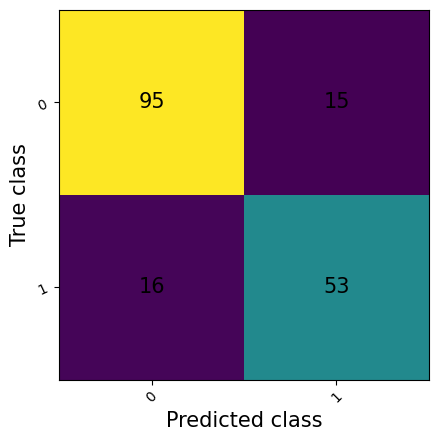

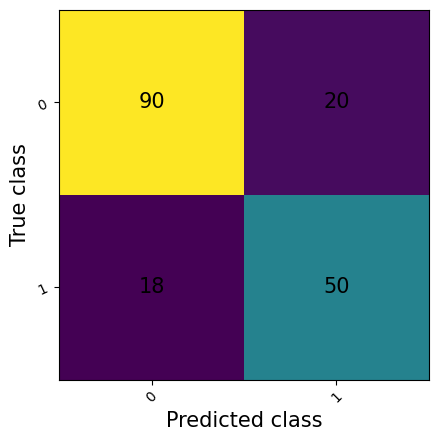

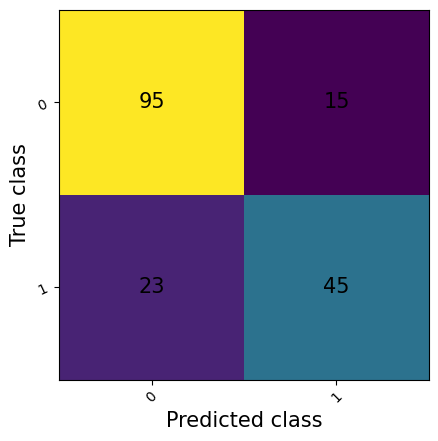

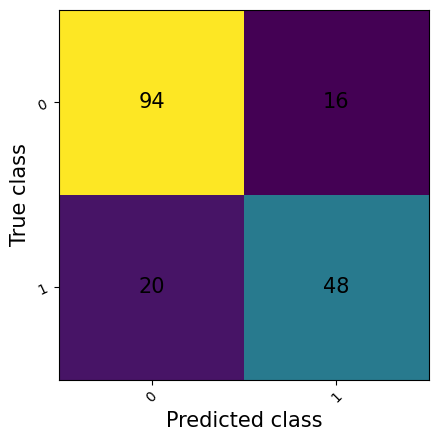

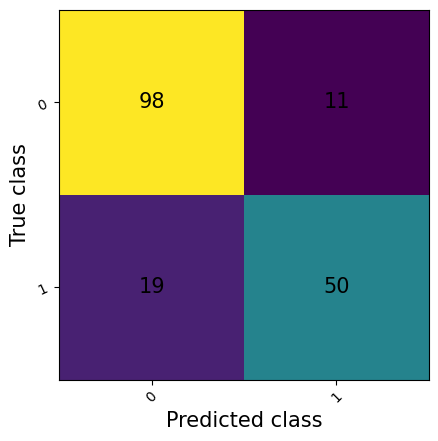

In [7]:
from metric import cm_to_metrics

scores = {
  'accuracy': [],
  'precision': [],
  'recall': [],
  'f1': []
}

for bcm in history:
  bcm.plot()
  cm = bcm.compute().cpu().numpy()

  accuracy, precision, recall, f1 = cm_to_metrics(cm)

  scores['accuracy'].append(accuracy)
  scores['precision'].append(precision)
  scores['recall'].append(recall)
  scores['f1'].append(f1)

scores_df = pd.DataFrame(scores)
pd.concat([scores_df, scores_df.apply(['mean', 'std'])])

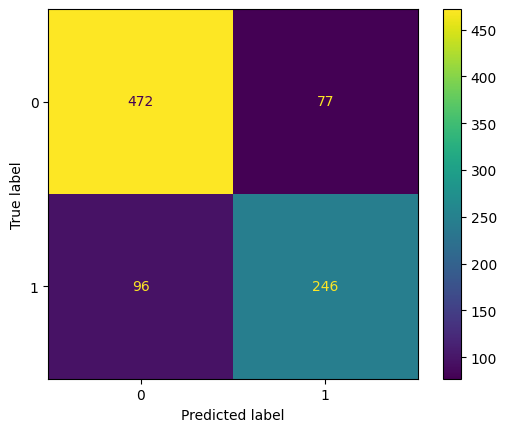

,accuracy,precision,recall,f1
0,0.805836,0.76161,0.719298,0.73985


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = sum([bcm.compute().cpu().numpy() for bcm in history])
ConfusionMatrixDisplay(cm).plot()
plt.show()

accuracy, precision, recall, f1 = cm_to_metrics(cm)

pd.DataFrame({'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1': [f1]})

In [9]:
X, y = torch.tensor(X_train), torch.tensor(y_train).unsqueeze(-1)

ds = TensorDataset(X, y)
# ds = CustomDataset(X, y)
dl = DataLoader(ds, batch_size=32, shuffle=True)

net = ANN(input_dim=14).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

pbar = tqdm(range(300))
for j in pbar:
  loss = train_one_epoch(net, nn.functional.binary_cross_entropy, optimizer, dl, device)
  pbar.set_postfix(trn_loss=loss)

100%|██████████| 300/300 [00:19<00:00, 15.12it/s, trn_loss=0.443]
